Meher Shashwat Nigam
20171062

# Imports

In [1]:
# Imports 
import os
import cv2
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt 
from os.path import isfile, join
%matplotlib inline

# Helper functions
## Display optical flow result
Displays the two images, optical flow vector values(u and v), magnitude, angle, optical flow arrows, flow mask.

In [2]:
def display_opticalflow_results(im1,im2,u,v,fig_size=(16,16),arrow_thres=0.02):

    fig = plt.figure(figsize=fig_size)
    
    #     Images
    ax = fig.add_subplot(3,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Image T:1")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,2)
    ax.imshow(im2,cmap='gray')
    ax.set_title("Image T:2")
    ax.axis('off')
    
    # Vectors     
    ax = fig.add_subplot(3,2,3)
    ax.imshow(u,cmap='gray')
    ax.set_title("U")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,4)
    ax.imshow(v,cmap='gray')
    ax.set_title("V")
    ax.axis('off')
    
    # Magnitude     
    ax = fig.add_subplot(3,2,5)
    ax.imshow(np.sqrt(u*u + v*v),cmap='gray')
    ax.set_title("U^2 + V^2")
    ax.axis('off')
    
    # Angle
    ax = fig.add_subplot(3,2,6)
    ax.imshow(np.arctan2(v,u),cmap='gray')
    ax.set_title("arc(v/u)")
    ax.axis('off')

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Optical flow Arrows")
    ax.axis('off')

    kp = cv2.goodFeaturesToTrack(im1, 100, 0.01, 10, 3)
    for arrow_ind in kp:
        x,y = arrow_ind[0]
        y = int(y)
        x = int(x)
        ax.arrow(x,y,u[y,x],v[y,x],head_width = 1, head_length = 5, color = (0,1,0))
        
    ax = fig.add_subplot(1,2,2)
    ax.imshow( (u*u + v*v>arrow_thres),cmap='gray')
    ax.set_title("Optical flow Mask")
    
    ax.axis('off')
   

    plt.show()

## Extracting frames and making a video from frames at given fps

In [24]:
def makeVideo(pathIn,pathOut,fps):
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    files.sort(key = lambda x: int(x[3:-4]))
    frame_array = []

    for i in range(len(files)):
        filename=pathIn + files[i]
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        frame_array.append(img)
        
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()
    
def getFrames(videofile,frameRate):
    vidcap = cv2.VideoCapture(videofile)
    sec = 0
    count=0
    success = True
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        success,image = vidcap.read()
        if success:
            cv2.imwrite("in2/image"+str(count)+".jpg", image)     # save frame as JPG %%file
        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)

# Lucas Kanade Optical flow algorithm
Optical flow is the pattern of apparent motion of image objects between two consecutive frames caused by the movemement of object or camera. It is 2D vector field where each vector is a displacement vector showing the movement of points from first frame to second.

`The Lucas-Kanade algorithm makes some implicit assumptions:`

    - The two images are separated by a small time increment ∆t, in such a
    way that objects have not displaced significantly (that is, the algorithm
    works best with slow moving objects).

    - The images depict a natural scene containing textured objects exhibiting shades of gray (different intensity  levels) which change smoothly.

![title](lk.jpg)

`Potential causes of errors in the algorithm:`
    - Suppose that A'A is not invertible.
    - Intensity is not almost constant between frames.
    - A point does not move like it's neighbours maybe because window size is too large.
    - Not prone to occlusions.

In [5]:
def optical_flow(I1g, I2g, window_size, tau=1e-2):
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])
    
    w = int(window_size/2)     
    I1g = I1g / 255. 
    I2g = I2g / 255.

    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode='same')
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode='same')
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode='same') + \
        signal.convolve2d(I1g, -kernel_t, boundary='symm', mode='same')
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)

    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
                        
            ATA = [ [ np.sum(Ix*Ix),np.sum(Ix*Iy)], [np.sum(Iy*Ix), np.sum(Iy*Iy)] ]
            ATA = np.array(ATA) 
            ATb = [-np.sum(Ix*It), -np.sum(Iy*It)]
            ATb = np.array(ATb) 
        
            eig,_ = np.linalg.eigh(ATA)
            
            if np.min(eig) < tau:
                u[i,j]=0
                v[i,j]=0  
            
            else:
                try:
                    nu = np.linalg.inv(ATA).dot(ATb)
                    u[i,j]=nu[0]
                    v[i,j]=nu[1]
                except Exception as e:
                    print(ATA,ATb,e)
                
    return [u,v]

# Analysis and Results

    - As can be seen, the algorithm performs best if the motion of the moving object(s) in between consecutive frames is slow. 
    - To the contrary, if the motion is large, the algorithm fails and we should implement / use multiple-scale version Lucas-Kanade with image pyramids.
    - Finally,  with small window size,  the algorithm captures subtle motions but not large motions. With large size it happens the other way.

## Image pairs
We will be using this optical flow dataset: http://vision.middlebury.edu/flow/data/.
Here are results on image pairs from the above dataset:

In [ ]:
img_dir ='./eval-data-gray/'
img_pair_list = []
for dirname in os.listdir(img_dir):
    if os.path.isdir(os.path.join(img_dir,dirname)):
        im1_path,im2_path = os.listdir(os.path.join(img_dir,dirname))

        im1 = cv2.imread(os.path.join(img_dir,dirname,im1_path),0)
        im2 = cv2.imread(os.path.join(img_dir,dirname,im2_path),0)
        img_pair_list.append([im1,im2])
    else:
        print("File if not a dir",dirname)

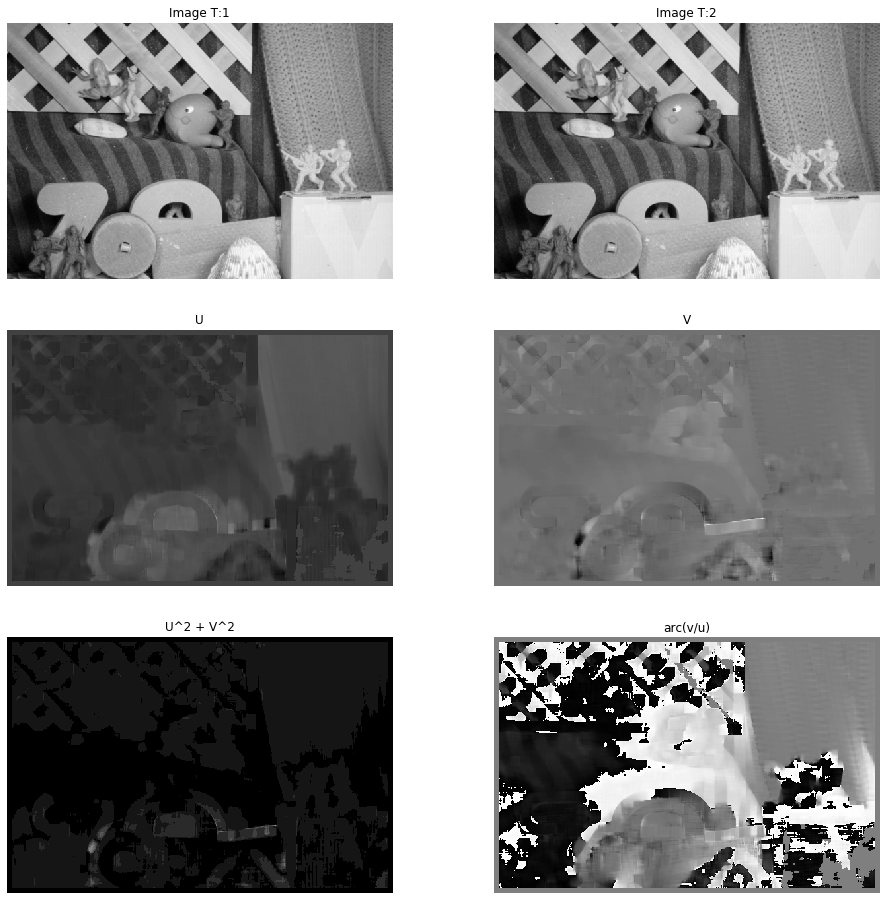

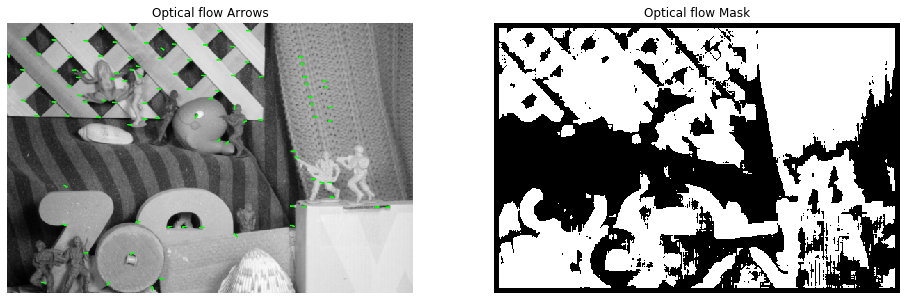

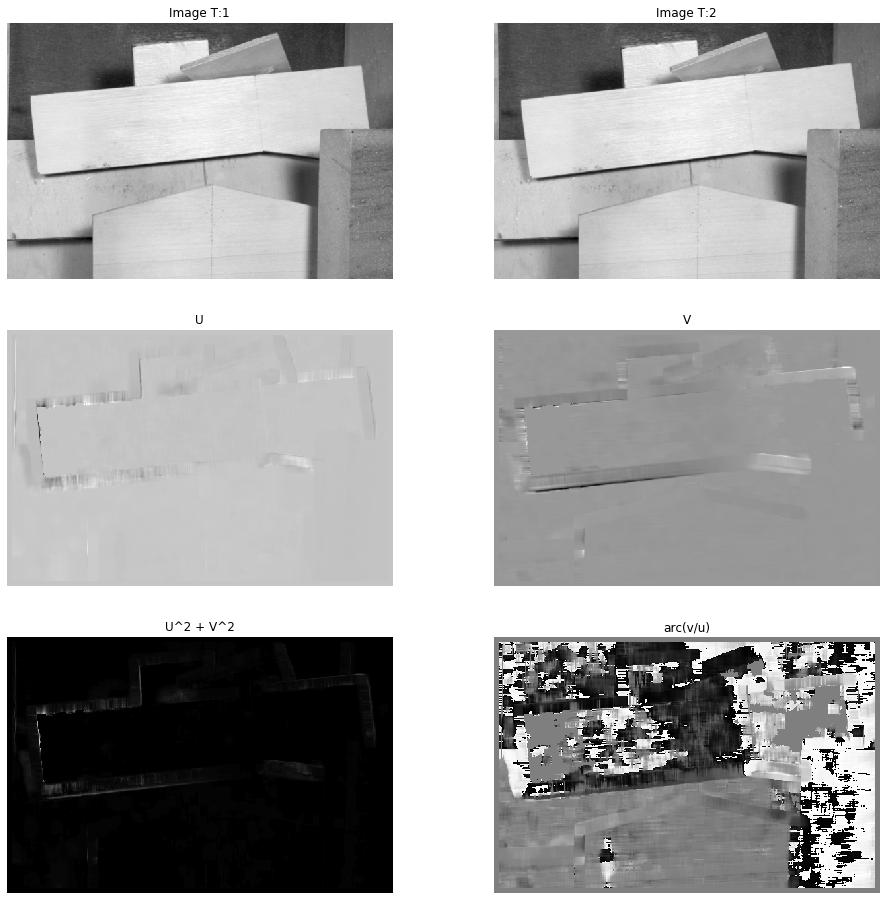

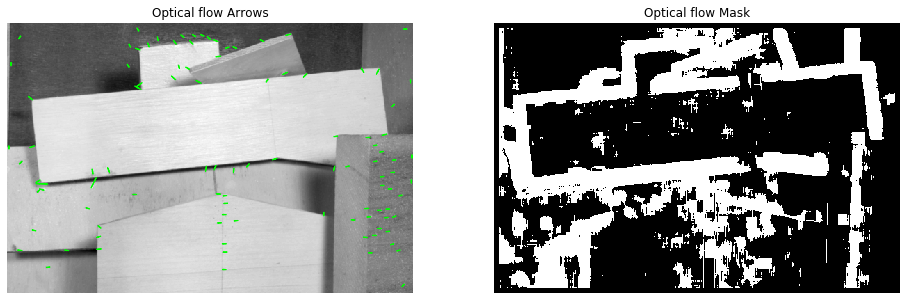

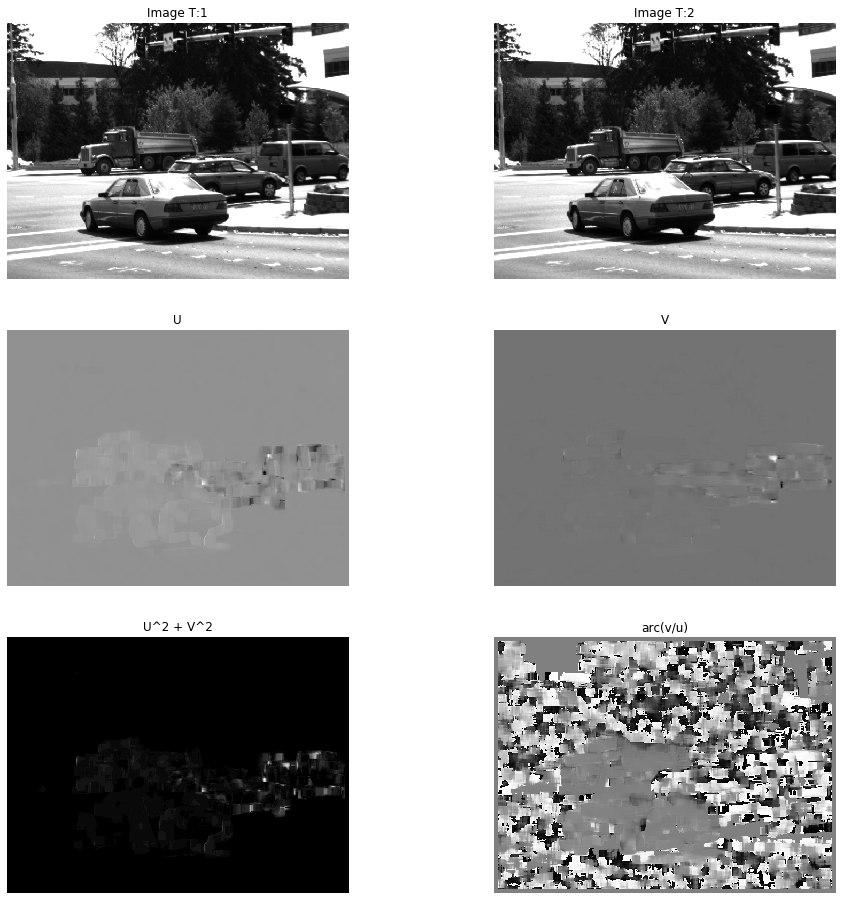

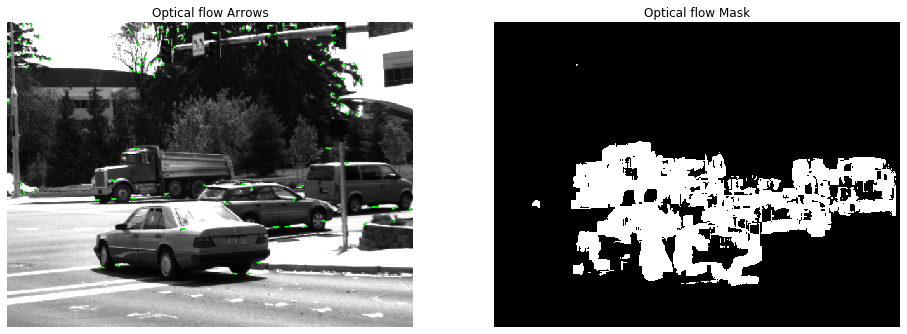

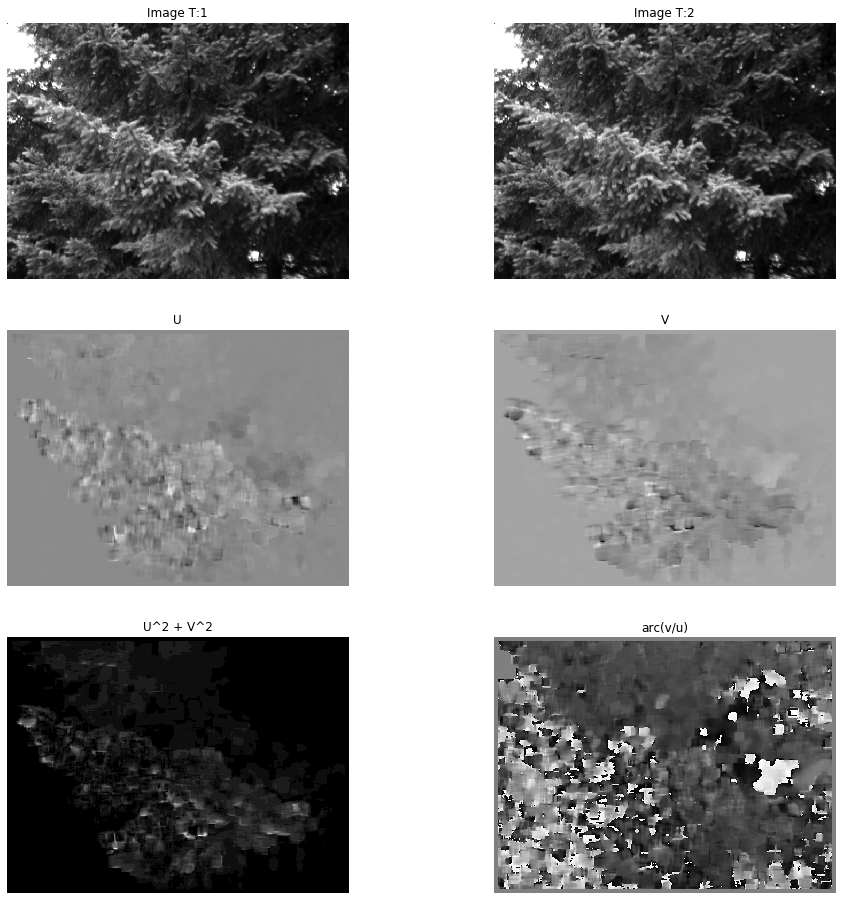

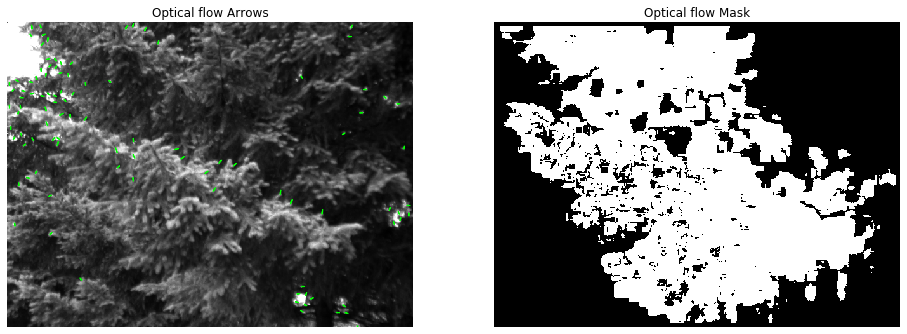

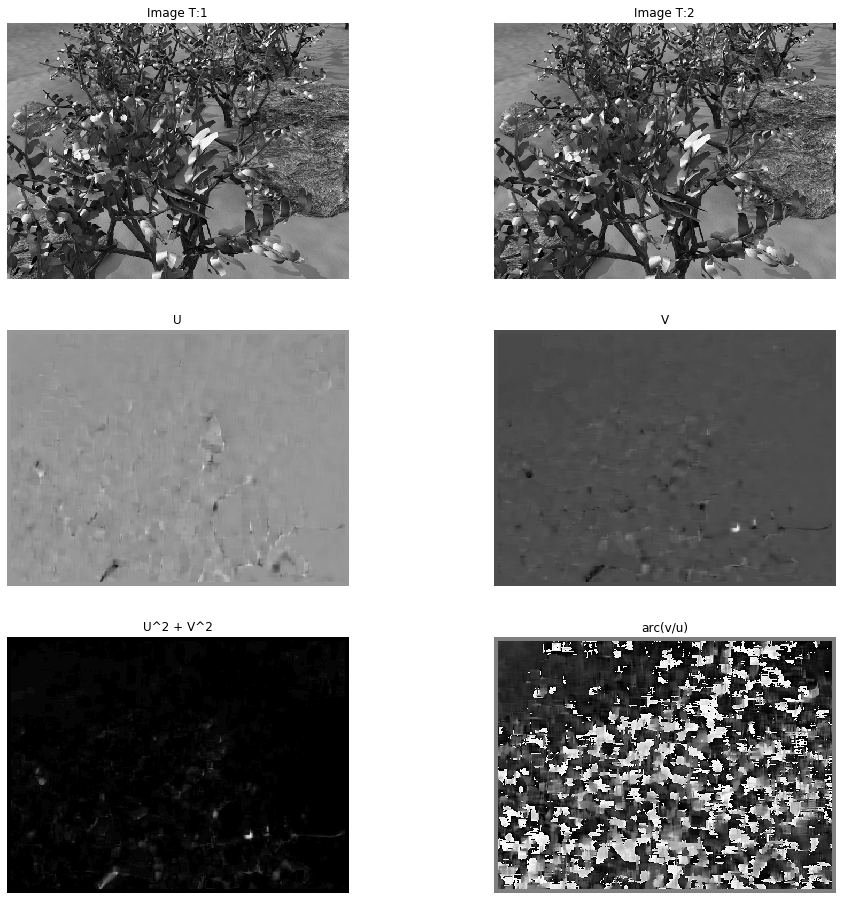

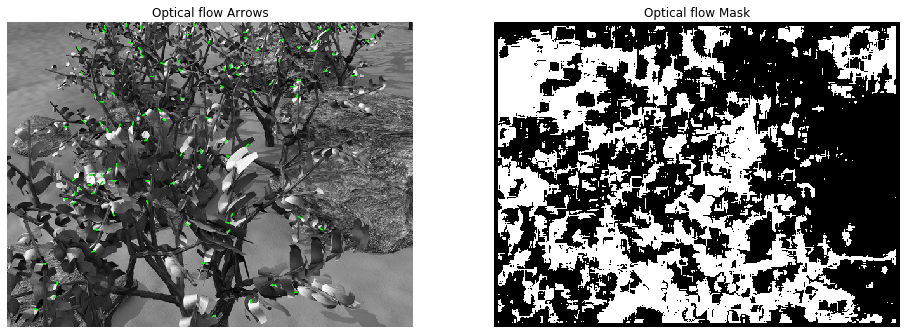

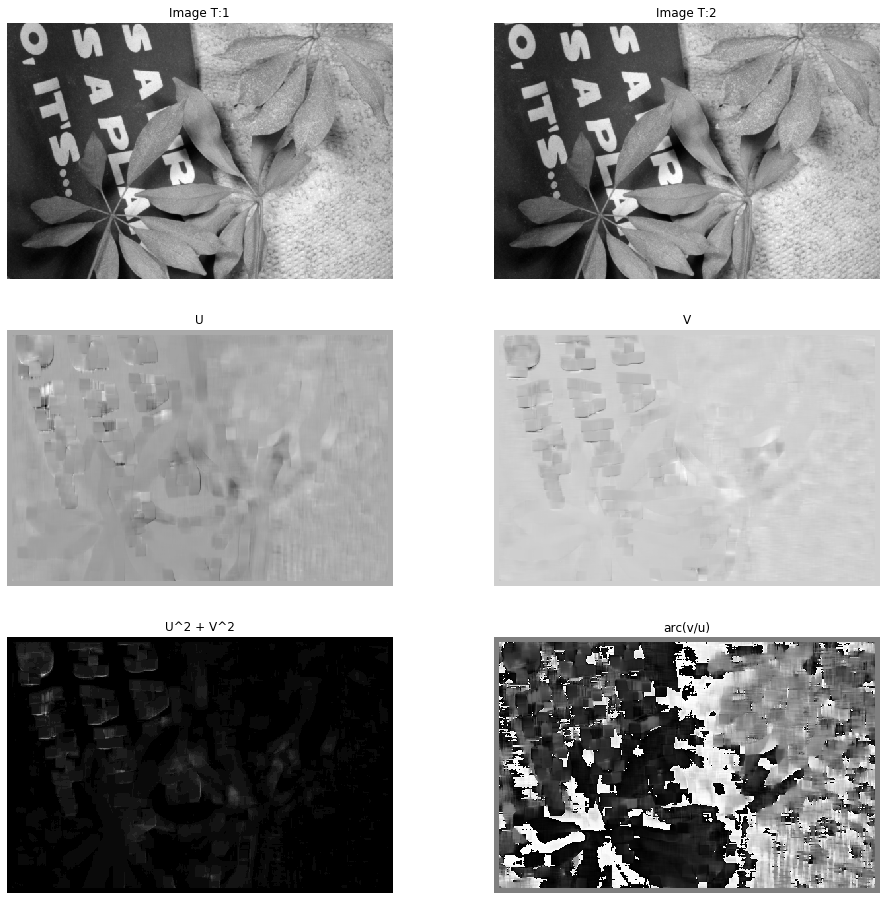

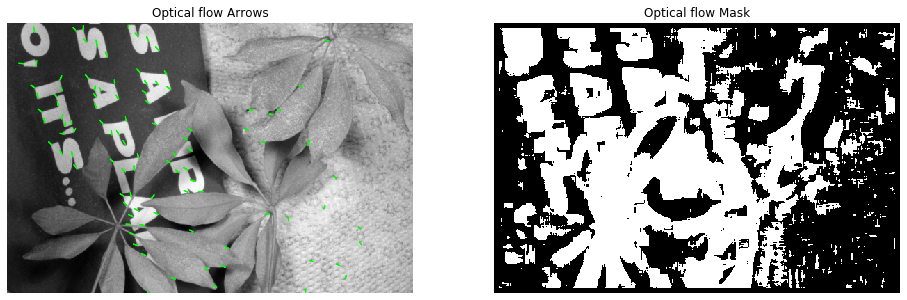

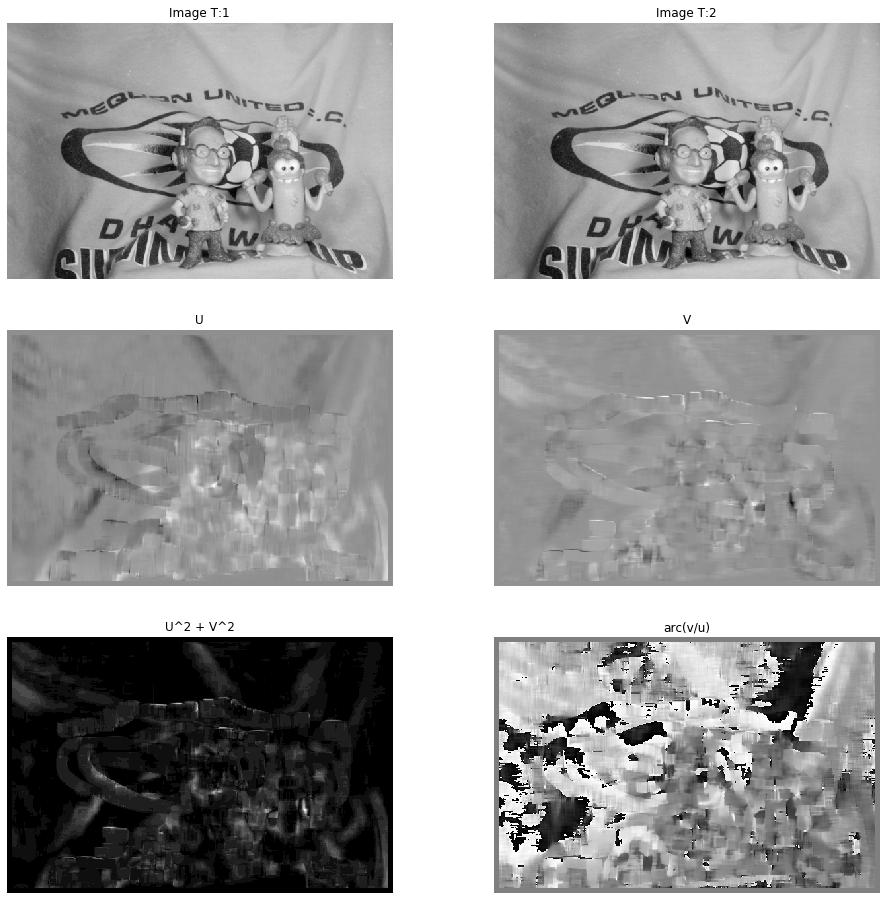

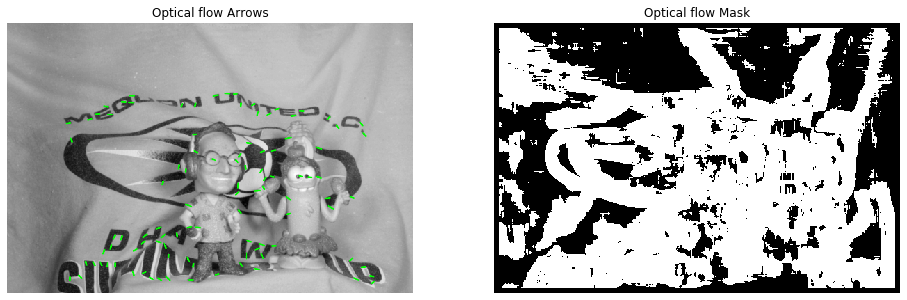

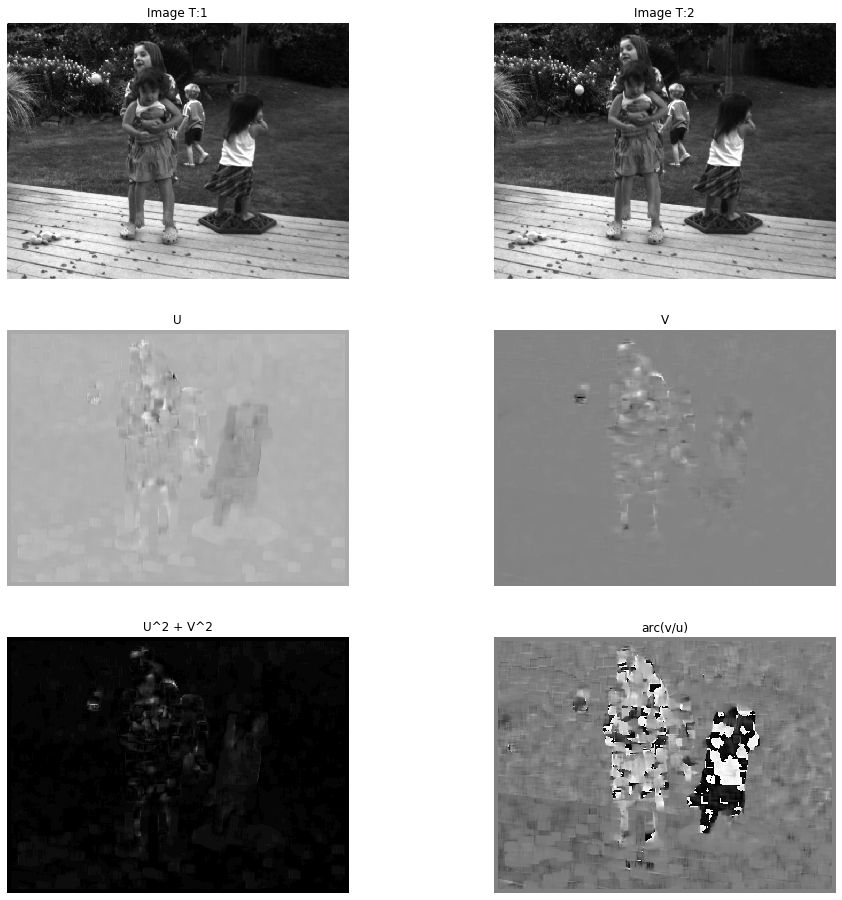

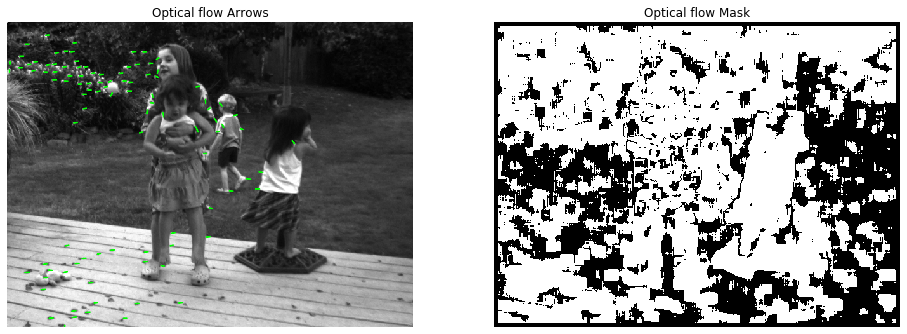

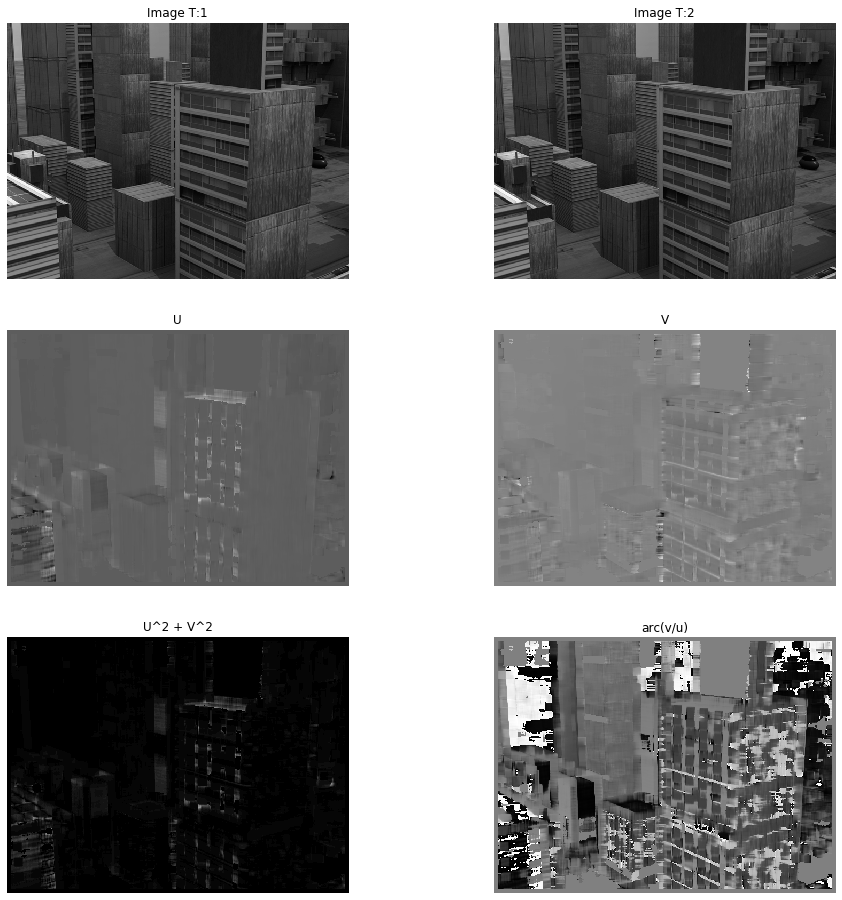

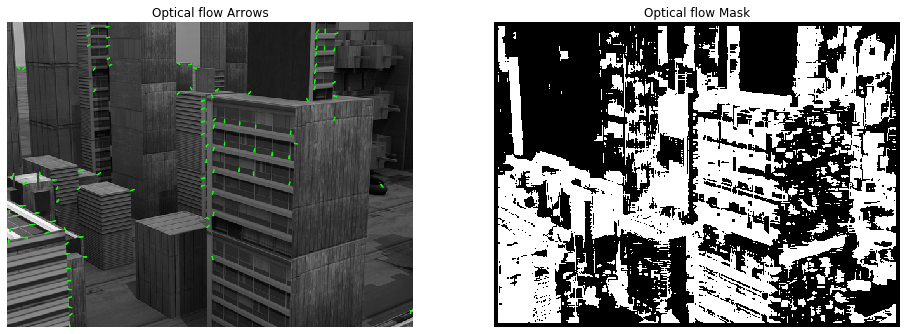

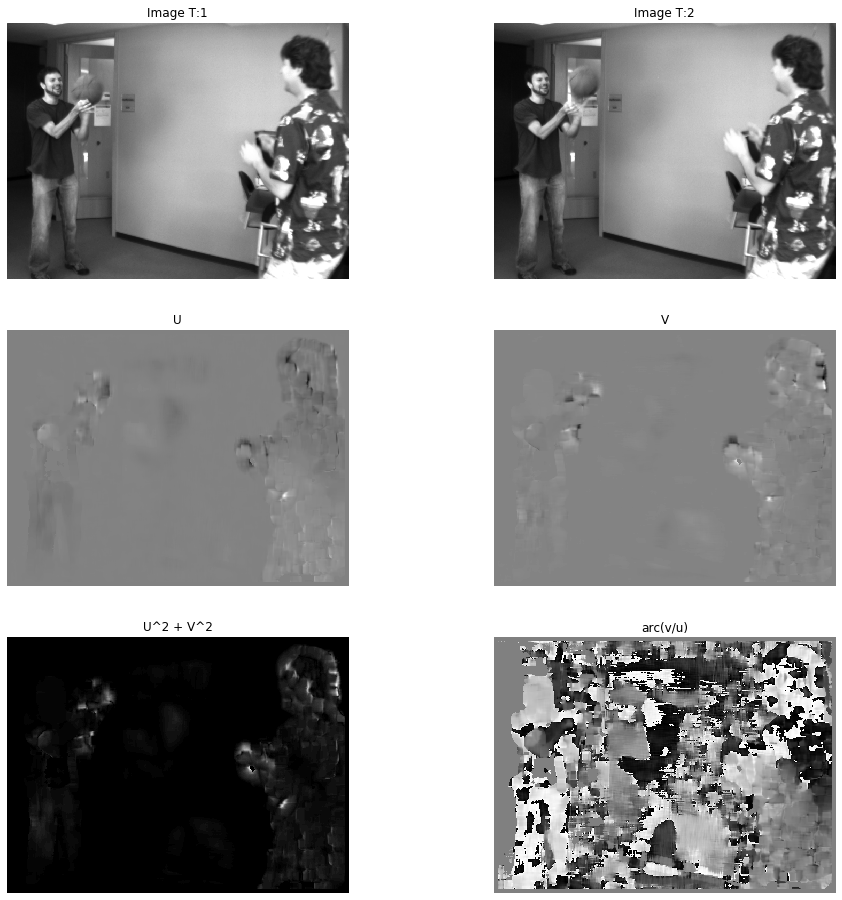

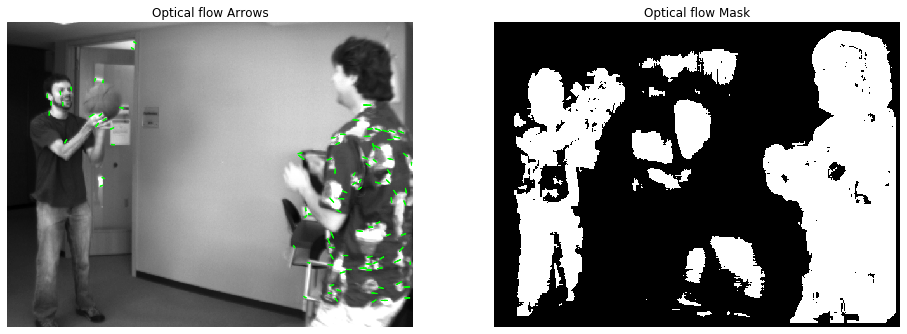

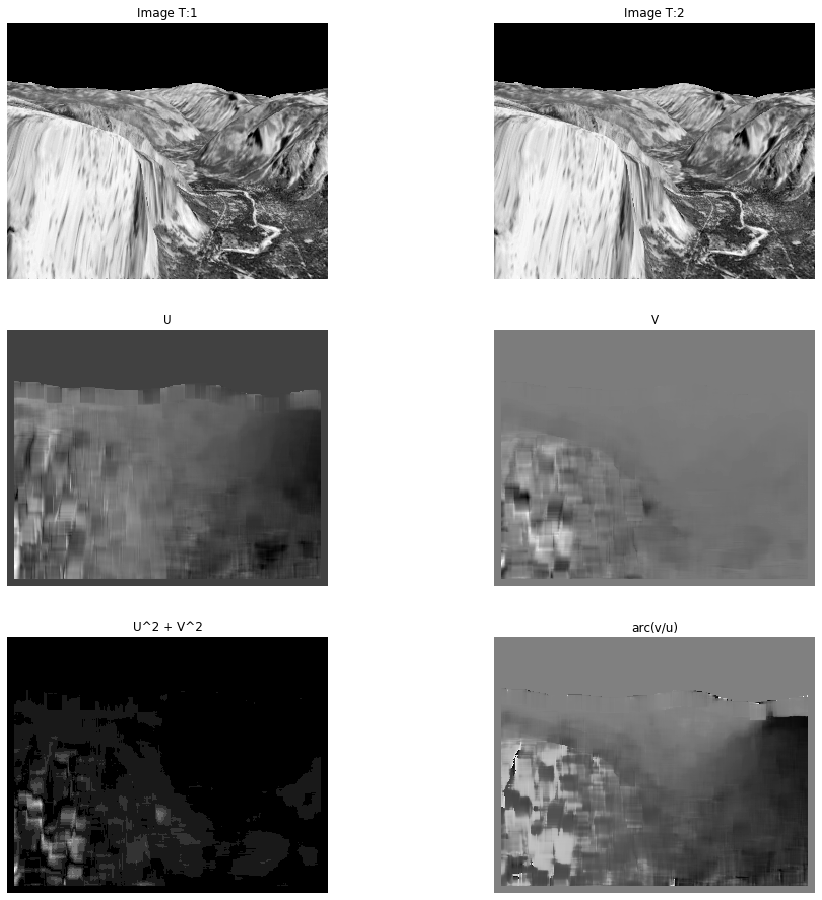

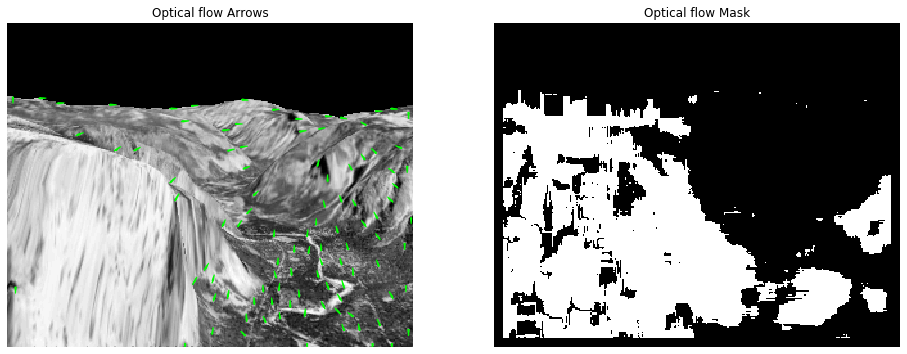

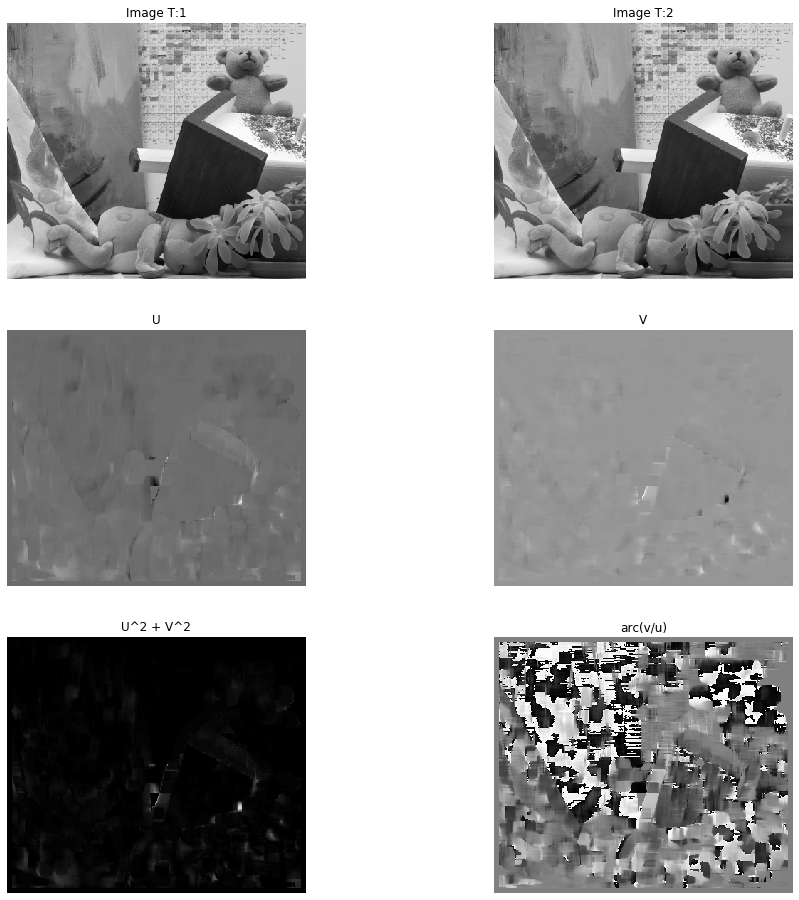

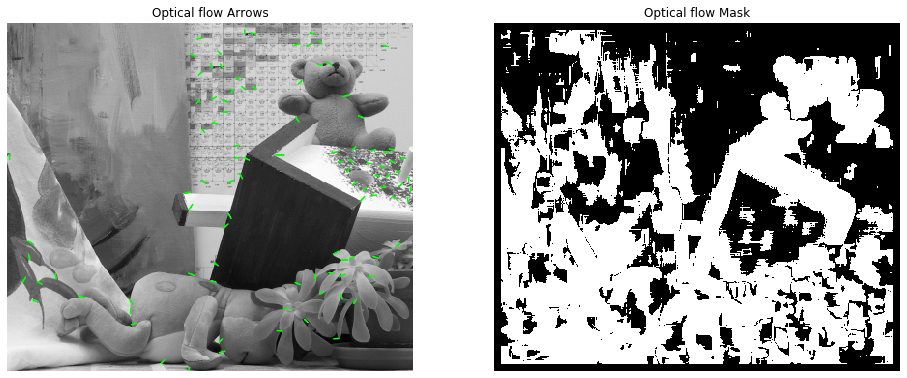

In [17]:
# Calculate optical flow on images
cnt = 0
for image_pair in img_pair_list:
    cnt +=1 
    im1,im2 = image_pair
    u,v = optical_flow(im1,im2,window_size=15)
    display_opticalflow_results(im1,im2,u,v,arrow_thres=1)  

## Detection and segmentation of moving objects from videos 

![title](taxi.gif)

In [18]:
cap = cv2.VideoCapture("taxi.gif")
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
count = 1

while(1):
    ret, frame2 = cap.read()
    if not ret:
        cap.release()
        cv2.destroyAllWindows()
        break
        
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    u,v = optical_flow(prvs,next,15)
    mag, ang = cv2.cartToPolar(u,v)
    
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    cv2.imwrite("op/image"+str(count)+".jpg", rgb)     # save frame as JPG %%file
    count+=1
    prvs = next

cap.release()
cv2.destroyAllWindows()
makeVideo('./op/','opvideo.mp4',10)

![title](opvideo.gif)

## Bounding box Tracking
![title](seq.gif)

In [ ]:
getFrames('seq.gif',0.2)
img_list = []

st = 10
en = 40

for i in range(st,en):   
    image = cv2.imread('./in2/image'+str(i)+'.jpg',0)
    img_list.append(image)
    
width = 80
diff = np.array([width//2,width//2])
w = 10
centroids = np.array([[195,298],[285,288],[275,219],[121,383]])
# centroids = np.array([[238,212],[118,267],[500,288]])
count = 0
for p in range(st,en):
    points = []
    prev = img_list[p-st]
    next = img_list[p+1-st]
    
    u,v = optical_flow(prev,next,15)
    
    for i in range(centroids.shape[0]):
        start_point = centroids[i]-diff
        end_point = centroids[i]+diff
        image = cv2.rectangle(prev, tuple(start_point), tuple(end_point),(0,255,0),2)
        
        tu = u[centroids[i][1]-w//2:centroids[i][1]+w//2,\
                   centroids[i][0]-w//2:centroids[i][0]+w//2]
        nzu = np.mean(tu[np.where(tu!=0)])
        tv = v[centroids[i][1]-w//2:centroids[i][1]+w//2,\
                   centroids[i][0]-w//2:centroids[i][0]+w//2]
        nzv = np.mean(tv[np.where(tv!=0)])
        centroids[i][1] -= nzv
        centroids[i][0] -= nzu
        
#         print(u[centroids[i][1],centroids[i][0]])
#         centroids[i][1] -= v[centroids[i][1],centroids[i][0]]
#         centroids[i][0] -= u[centroids[i][1],centroids[i][0]]
        centroids = centroids.astype(int)
              
    plt.imshow(image)
    cv2.imwrite("./opx/opx"+str(count)+".jpg", image)     # save frame as JPG %%file
    count += 1
makeVideo('./opx/','opxvideo.mp4',10)

![title](opxvideo.gif)

## Analyze how does your algorithm work when camera is moving
When camera is moving almost all the scene is segmented out as can be seen in the ouput of Backyard and Grove, this is because the entire scene is moving for the camera so all the pixels will have a change in their positions, whereas when the object is moving only the object is segmented out as can be seen in output of Evergreen and Dumptruck because only object is moving with respect to camera.